# Análisis Exploratorio de Datos (EDA)


#### Ya con los datos limpios, se procede a investigar las relaciones que hay entre las variables del dataset, ver si hay outliers o anomalías. Preparando nuestro Datasets final para el sistema de recomendación.

#### Se importan las librerías

In [17]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings("ignore")

#### Se importan los Datasets limpios

In [18]:
df_g = pd.read_csv(r'C:\Users\Cebol\OneDrive\Escritorio\Datasets\Datasets\steam_games_limpio.csv', encoding='utf-8')
df_r = pd.read_csv(r'C:\Users\Cebol\OneDrive\Escritorio\Datasets\Datasets\australian_user_reviews_limpio.csv', encoding='utf-8')
df_i = pd.read_csv(r'C:\Users\Cebol\OneDrive\Escritorio\Datasets\Datasets\australian_users_items_limpio.csv', encoding='utf-8')

<br>

## EDA del Dataset steam_games

#### Se observan el resumen estadístico para las variables numéricas y categóricas.

#### Se chequean los nulos y los tipos de columnas

In [19]:
mi_dict = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_g.columns:
    mi_dict["Campo"].append(columna)
    mi_dict["Tipo_de_dato"].append(df_g[columna].apply(type).unique())
    mi_dict["Nulos"].append(df_g[columna].isnull().sum())

df_info = pd.DataFrame(mi_dict)
df_info

,Campo,Tipo_de_dato,Nulos
0,genres,[<class 'str'>],0
1,title,[<class 'str'>],0
2,price,[<class 'float'>],0
3,item_id,[<class 'int'>],0
4,developer,[<class 'str'>],0
5,release_year,[<class 'str'>],0


Los valores nulos ya han sido abordados durante el ETL

## Variable numérica 'price'

##### Resumen estadístico del estado actual de las variables numérica 'price'

In [20]:
pd.options.display.float_format = '{:.2f}'.format
df_g.describe()

,price,item_id
count,71551.00,71551.00
mean,8.44,462594.66
std,15.77,174170.33
min,0.00,10.00
25%,1.99,341465.00
50%,4.99,456830.00
75%,9.99,598475.00
max,995.00,2028850.00


### Boxplot de la columna 'price'

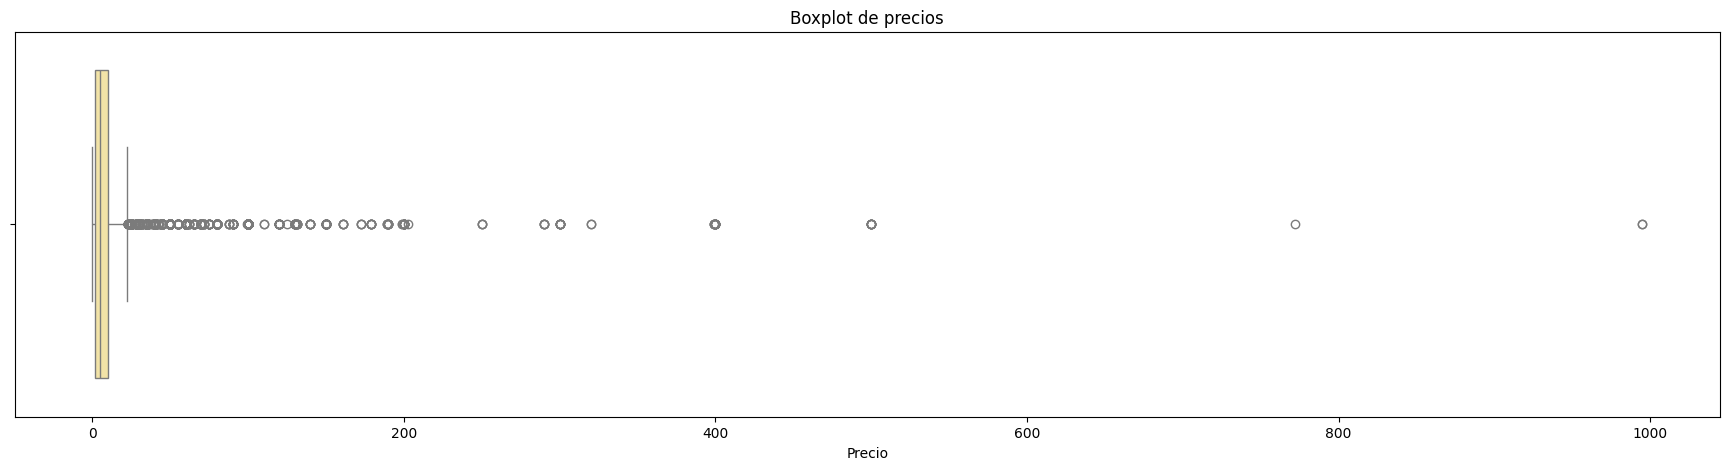

In [21]:
# Establecer la paleta de colores cálidos
sns.set_palette("YlOrRd")

# Boxplot
plt.figure(figsize=(22, 5))
sns.boxplot(data=df_g, x='price')
plt.title('Boxplot de precios')
plt.xlabel('Precio')
plt.show()

De las visualizaciones anteriores, se ve que la variable **price** contiene varios outliers. Conociendo la industria gamming, y conociendo la plataforma de steam, puedo afirmar que los precios cercano a 200 usd se debe a juegos que vienen con expansiones o contenido adicional, por lo que se decide modificar los precios de los juegos mayores de 200 usd y NO utilizar z_score, y colocarles el valor de la mediana. 

In [22]:
# Modificamos los Outliers tomando los valores de la mediana
df_g["price"] = df_g["price"].where(df_g["price"] <= 200, df_g["price"].median())

### Histograma de la columna 'price'

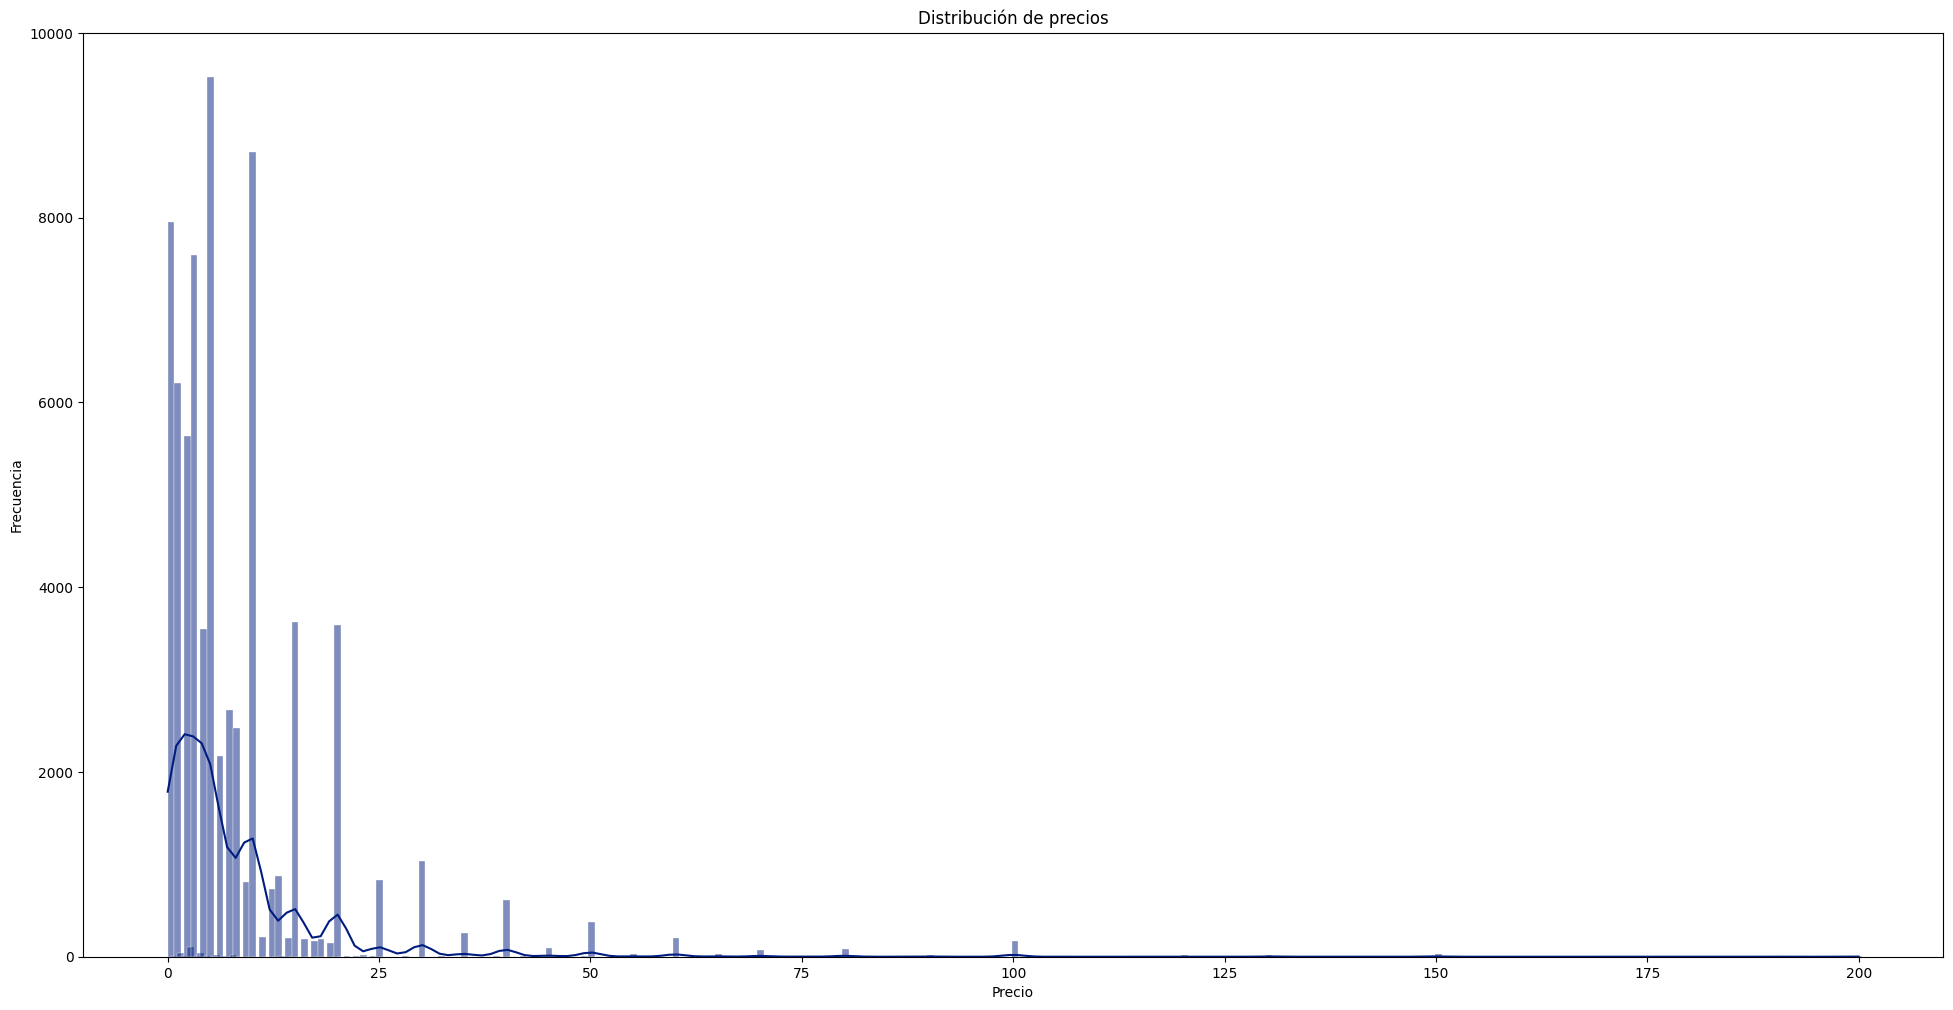

In [23]:
# Establecer la paleta de colores
sns.set_palette("dark")

# Histograma
plt.figure(figsize=(24, 12))
sns.histplot(data=df_g, x='price', kde=True)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Ajustar el ancho de las columnas y los colores
bars = plt.gca().patches
for bar in bars:
    bar.set_width(0.8)  # Ajustar el ancho de las columnas
    bar.set_edgecolor('white')  # Ajustar el color del borde de las columnas

plt.show()

El histograma de la columna 'price' muestra la distribución de los valores de precios en el conjunto de datos. Dado que el histograma muestra una mayor concentración de valores alrededor de 0 y 10, podemos inferir que la mayoría de los juegos tienen precios bajos o son "free to play". Sin embargo, también hay algunos juegos con precios más altos, como se evidencia en el valor máximo de 200 usd, habiendo modificado los outliers mayores a 200 usd, y se puede inferir, como mencioné anteriormente, que estos juegos se trata de juegos tipo bundle (juegos que contienen no solo el juego original, sino un pack con las expansiones de contenido del mismo).

## Variables Categóricas

#### En primer lugar se observa el resumne estadísticos de las varables categóricas y luego se visualizan las distribuciones de cada variable.

In [24]:
df_g.describe(include=['category', 'object'])

,genres,title,developer,release_year
count,71551,71551,71551,71551
unique,22,28818,10898,39
top,Indie,autotileset,ubisoft - san francisco,2017
freq,15858,11,2516,24967


#### Distribución de variables categórica 'genres'

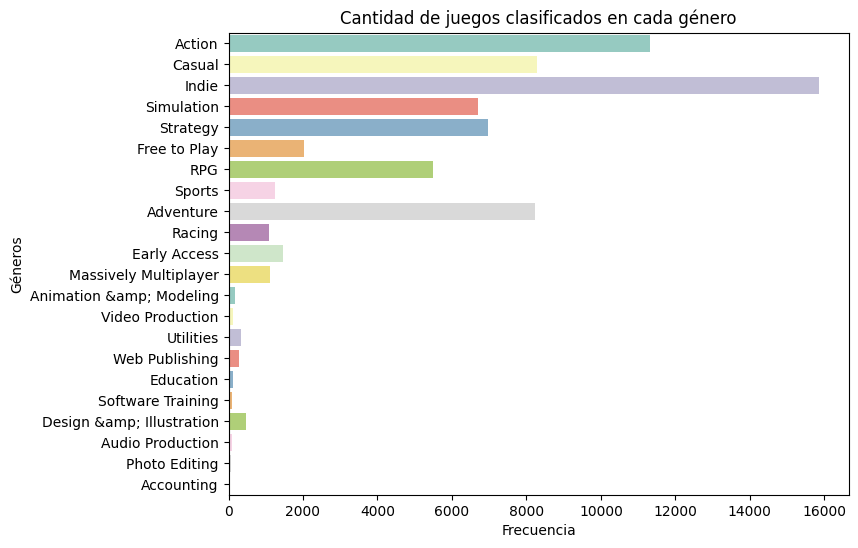

In [25]:
# Estilo
sns.set_palette("pastel")

# Count-plot de la columna 'genres'
plt.figure(figsize=(8, 6))
sns.countplot(data=df_g, y='genres', orient='h', palette='Set3')
plt.title('Cantidad de juegos clasificados en cada género')
plt.xlabel('Frecuencia')
plt.ylabel('Géneros')
plt.show()

In [26]:
def porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

porcentaje(df_g, 'genres')[:10]

,Cantidad,Porcentaje
genres,,
Indie,15858,22.16
Action,11319,15.82
Casual,8282,11.57
Adventure,8242,11.52
Strategy,6957,9.72
Simulation,6699,9.36
RPG,5479,7.66
Free to Play,2031,2.84
Early Access,1462,2.04


Según la distribución de géneros en el conjunto de datos, y considerando que un juego puede estar clasificado dentro de varios géneros de forma simultánea, se pueden obtener las siguientes conclusiones:

+ Los géneros más comunes son "Indie" y "Action". Esto indica que hay una gran cantidad de juegos en estos géneros.

+ Los géneros "Casual", "Adventure", "Strategy" y "Simulation" también tienen una presencia significativa. Esto sugiere que estos géneros también son populares.

+ Los géneros menos comunes incluyen "Accounting", "Photo Editing", "Audio Production" y "Software Training". Estos géneros representan una proporción muy pequeña del total del conjunto de datos.

En general, esta distribución de géneros proporciona una visión general de los tipos de juegos presentes en el conjunto de datos y puede ser útil para comprender las preferencias y tendencias en la industria de los videojuegos.

#### Distribución variable 'release_year'

In [27]:
def porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_resultado = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_resultado

porcentaje(df_g, 'release_year')[:5]

,Cantidad,Porcentaje
release_year,,
2017,24967,34.89
2016,17667,24.69
2015,12256,17.13
2014,6341,8.86
2013,3016,4.22


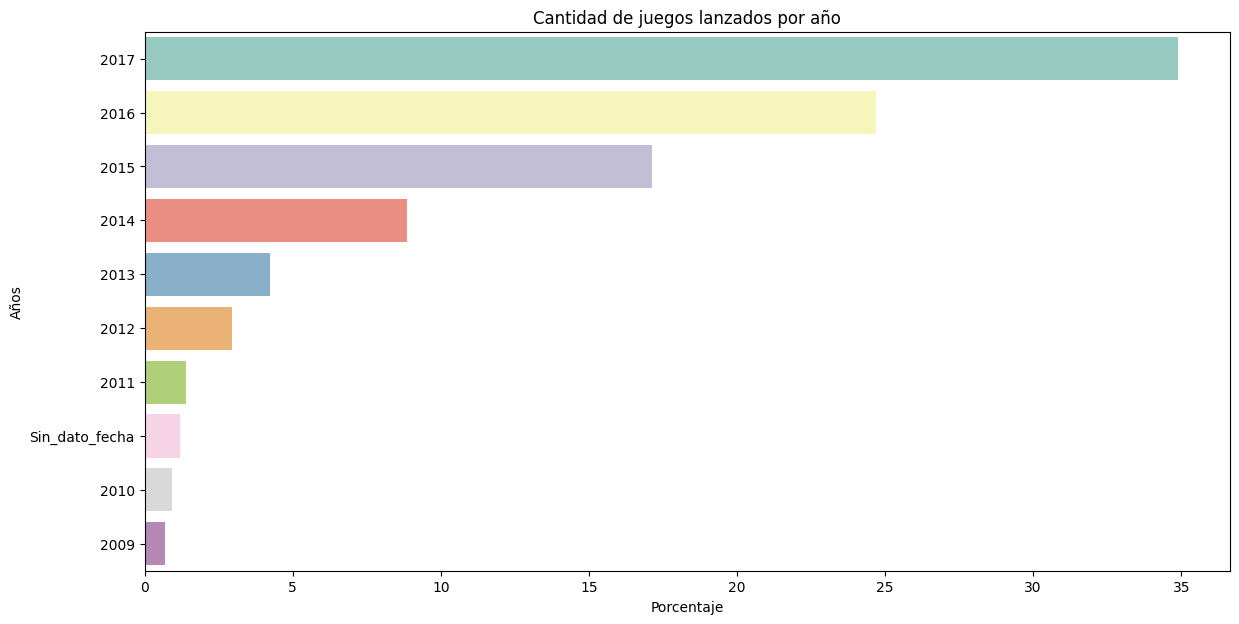

In [28]:
# Estilo
sns.set_palette("pastel")

df_porcentaje = porcentaje(df_g, 'release_year')[:10]

# Crear el count plot con el eje X mostrando el porcentaje
plt.figure(figsize=(14, 7))
sns.barplot(data=df_porcentaje, x='Porcentaje', y='release_year', orient='h', palette='Set3')
plt.title('Cantidad de juegos lanzados por año')
plt.xlabel('Porcentaje')
plt.ylabel('Años')
plt.show()

Se puede inferir que la industria de los videos juegos se encuentra en pleno crecimiento, porque si hay tantos lanzamientos de juegos en estos ultimos años, es porque existe un mercado para ellos que los consume. Cabe destacar que no existen datos a partir de 2017 a la fecha, por lo menos en los Datasets provistos. 

#### Distribución variable 'developer'

In [29]:
def porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(1000 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

porcentaje(df_g, 'developer')[:10]

,Cantidad,Porcentaje
developer,,
ubisoft - san francisco,2516,35.16
"smiteworks usa, llc",2364,33.04
dl softworks,495,6.92
ronimo games,379,5.30
paradox development studio,311,4.35
Sin Datos,285,3.98
musopia,285,3.98
arcane raise,265,3.70
dovetail games,256,3.58


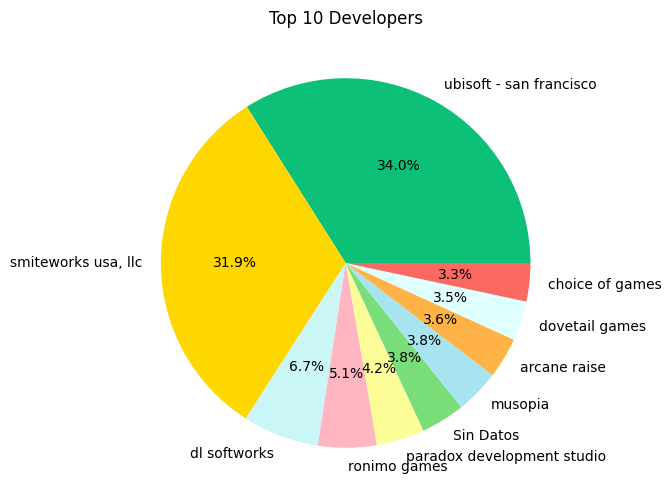

In [30]:
# Contar la cantidad de juegos por developer
conteo_developer = df_g['developer'].value_counts()

# Crear el gráfico de torta
plt.figure(figsize=(6, 6))
conteo_developer[:10].plot(kind='pie', autopct='%1.1f%%', colors=['#0CC078', '#FFD700',
 '#CBF6F8', '#FFB6C1', '#FCFC99', '#79DE79', '#A8E4EF', '#FFB347', '#E0FFFF', '#FB6962'])
plt.title('Top 10 Developers')
plt.ylabel('')

# Mostrar el gráfico
plt.show()

De este análisis, nos podemos dar cuenta que las desarrolladoras Ubisoft y Smiteworks abarcan casi un 70% de los juegos disponibles en la plataforma, desconocemos si tienen algun tipo de convenio de publicación de los títulos, pero es llamativa la ausencia de otras grandes desarrolladoras.

<br>

## EDA del Dataset user_reviews

#### Se observan el resumen estadístico para las variables numéricas y categóricas.

#### Se chequean los nulos y los tipos de columnas

In [31]:
mi_dict = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_r.columns:
    mi_dict["Campo"].append(columna)
    mi_dict["Tipo_de_dato"].append(df_r[columna].apply(type).unique())
    mi_dict["Nulos"].append(df_r[columna].isnull().sum())

df_info = pd.DataFrame(mi_dict)
df_info

,Campo,Tipo_de_dato,Nulos
0,item_id,[<class 'float'>],0
1,recommend,[<class 'bool'>],0
2,review,[<class 'str'>],0
3,user_id,[<class 'str'>],0
4,sentiment_analysis,[<class 'int'>],0


Los valores nulos ya han sido abordados durante el ETL

#### Distribución variable 'sentiment analysis' y 'review_recommend'.

In [32]:
def porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

porcentaje(df_r, 'sentiment_analysis')

,Cantidad,Porcentaje
sentiment_analysis,,
2,964,64.27
1,281,18.73
0,255,17.00


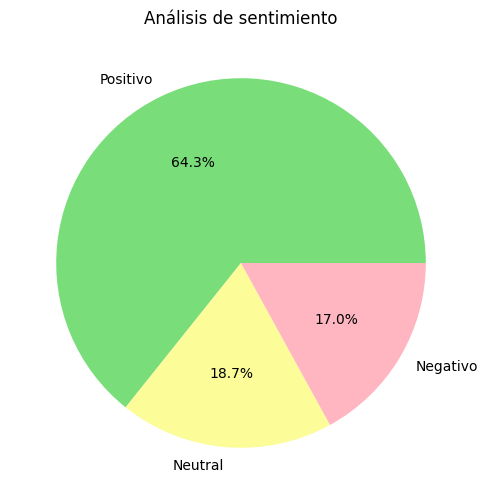

In [33]:
# Contar la cantidad de positivo, neutros y negativos
conteo_sentimiento = df_r['sentiment_analysis'].value_counts()

# Crear el gráfico de torta con etiquetas personalizadas
plt.figure(figsize=(6, 6))
colores = ['#79DE79', '#FCFC99', '#FFB6C1']
etiquetas = ['Positivo', 'Neutral', 'Negativo']
plt.pie(conteo_sentimiento, labels=etiquetas, autopct='%1.1f%%', colors=colores)
plt.title('Análisis de sentimiento')
plt.ylabel('')

# Mostrar el gráfico
plt.show()

In [34]:
def porcentaje(df, columna):
    # Cuenta la cantidad de True/False luego calcula el porcentaje
    counts = df[columna].value_counts()
    percentages = round(100 * counts / len(df),2)
    # Crea un dataframe con el resumen
    df_results = pd.DataFrame({
        "Cantidad": counts,
        "Porcentaje": percentages
    })
    return df_results

porcentaje(df_r, 'recommend')

,Cantidad,Porcentaje
recommend,,
True,1310,87.33
False,190,12.67


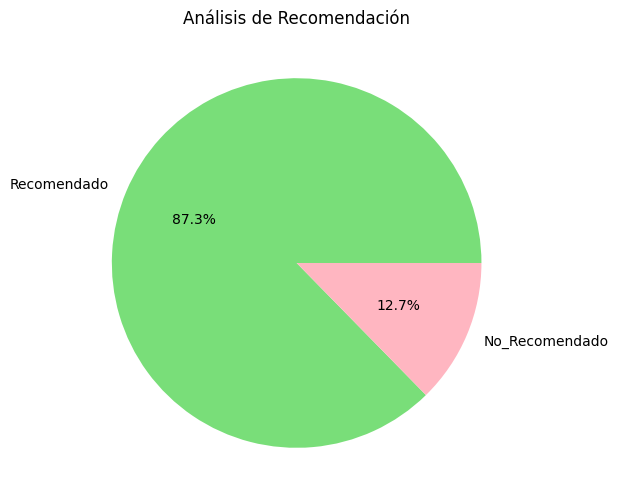

In [35]:
# Contar la cantidad de juegos recomendados
conteo_recomendacion = df_r['recommend'].value_counts()

# Crear el gráfico de torta con etiquetas personalizadas
plt.figure(figsize=(6, 6))
colores = ['#79DE79', '#FFB6C1']
etiquetas = ['Recomendado', 'No_Recomendado']
plt.pie(conteo_recomendacion, labels=etiquetas, autopct='%1.1f%%', colors=colores)
plt.title('Análisis de Recomendación')
plt.ylabel('')

# Mostrar el gráfico
plt.show()

Despues de analizar ambas variables, se observa que el análisis de sentimiento realizado está bastante acertado, teniendo en cuenta que entre análisis positivo y neutral, se alcanza un 83% de las reviews, lo que coincide con el 88% de juegos recomendados.

<br>

## EDA del Dataset users_items

#### Se observan el resumen estadístico para las variables numéricas y categóricas.

#### Se chequean los nulos y los tipos de columnas

In [36]:
mi_dict = {"Campo": [], "Tipo_de_dato": [], "Nulos": []}

for columna in df_i.columns:
    mi_dict["Campo"].append(columna)
    mi_dict["Tipo_de_dato"].append(df_i[columna].apply(type).unique())
    mi_dict["Nulos"].append(df_i[columna].isnull().sum())

df_info = pd.DataFrame(mi_dict)
df_info

,Campo,Tipo_de_dato,Nulos
0,item_id,[<class 'float'>],0
1,item_name,[<class 'str'>],0
2,playtime_forever,[<class 'float'>],0
3,user_id,[<class 'str'>],0
4,items_count,[<class 'int'>],0


Los valores nulos ya han sido abordados durante el ETL

Para recordar, contiene la información relacionada los usuarios y los juegos que consumen como el tiempo acumulado (en minutos) que han jugado a un juego, la cantidad de items que poseen en sus bibliotecas, los id de los juegos y del propio usuario.

### Variable numérica 'playtime_forever'

Suponiendo que los datos de ésta columna se encuentran en minutos, se procede a la conversión de la misma a horas.

In [37]:
df_i['playtime_forever'] = df_i['playtime_forever']/60

##### Resumen estadístico del estado actual de las variables numérica 'playtime_forever'

In [38]:
df_i['playtime_forever'].describe()

count   5094092.00
mean         16.51
std          90.24
min           0.00
25%           0.00
50%           0.57
75%           5.92
max       10712.88
Name: playtime_forever, dtype: float64

#### Violin-plot para la variable 'playtime_forever', convertido a horas

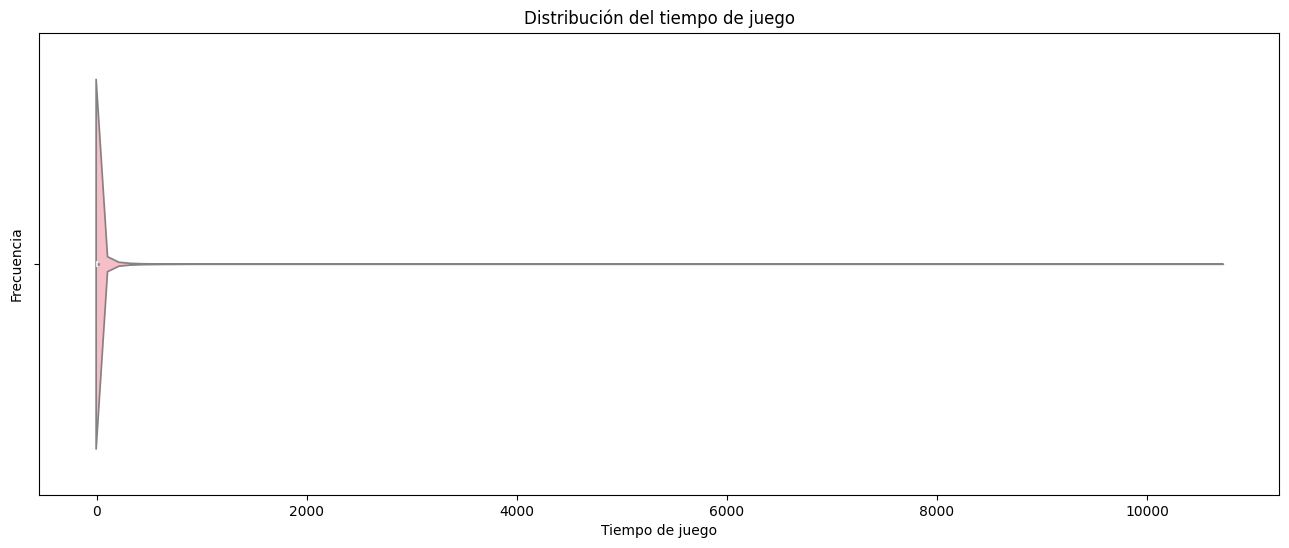

In [39]:
# Violin plot
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_i['playtime_forever'], color='#FFB6C1', orient='h')
plt.title('Distribución del tiempo de juego')
plt.xlabel('Tiempo de juego')
plt.ylabel('Frecuencia')
plt.show()

Según lo analizado, se puede observar que cada usuario, por juego, pasa un tiempo medio de 0.57 horas jugando y el 75% de los jugadores estuvieron menos de 6 hs jugando a un mismo juego, pero se observa una gran cantidad de valores atípicos por encima de las 14.79 hs que juega cada usuario a un mismo juego. Son valores atípicos, pero considerando que 10.000 horas son 416 días, para juegos que llevan tantos años en el mercado, no es descabellado pensar que son datos reales, por lo que decido no imputarlos, ni modificarlos.

##### Resumen estadístico del estado actual de las variables numérica 'items_count'

In [40]:
df_i['items_count'].describe()

count   5094092.00
mean        315.73
std         696.91
min           1.00
25%          71.00
50%         137.00
75%         275.00
max        7762.00
Name: items_count, dtype: float64

#### Boxplot de la columna 'item_count'

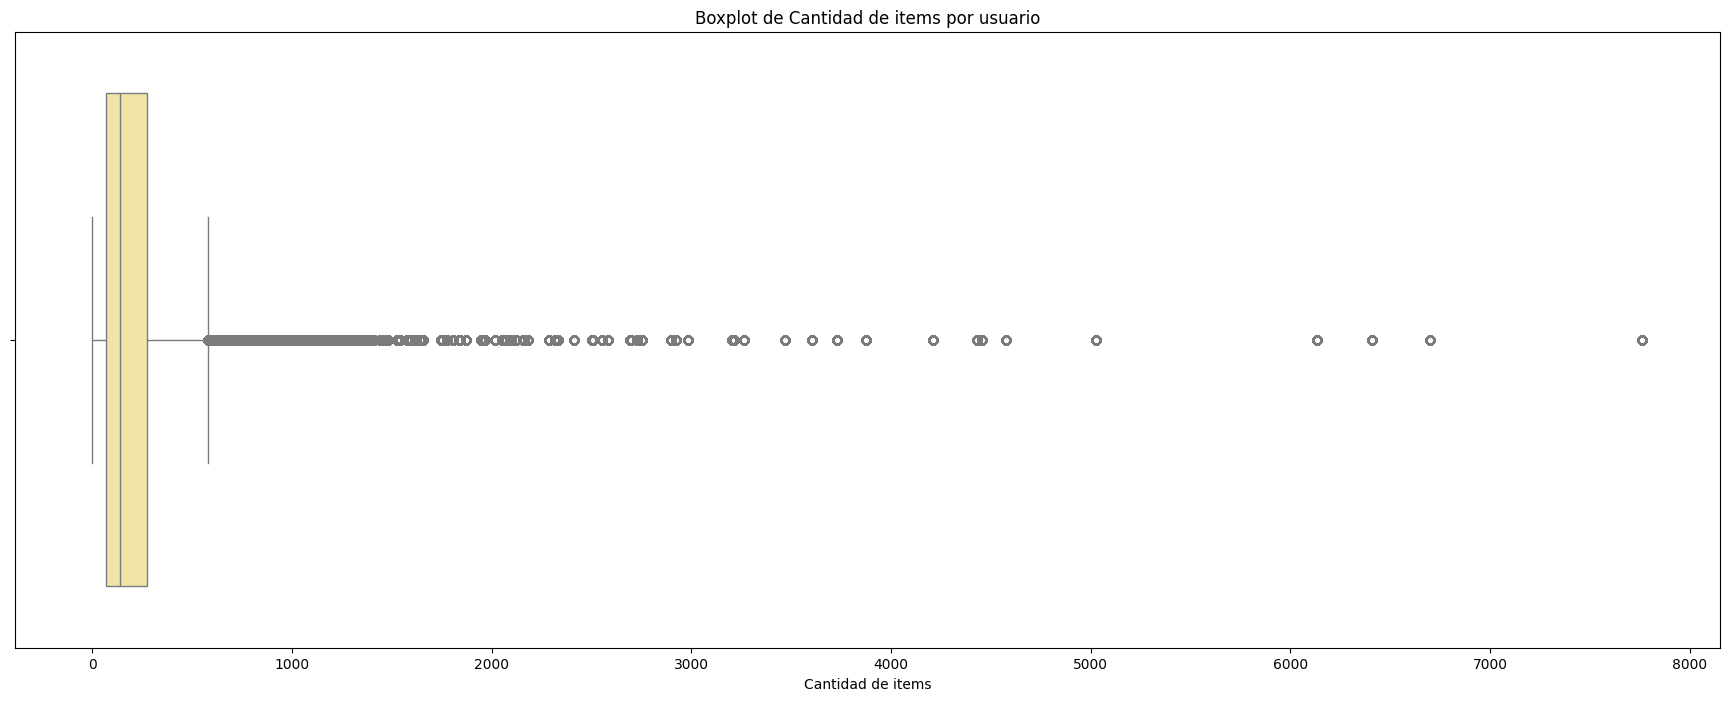

In [41]:
# Establecer la paleta de colores cálidos
sns.set_palette("YlOrRd")

# Boxplot
plt.figure(figsize=(22, 8))
sns.boxplot(data=df_i, x='items_count')
plt.title('Boxplot de Cantidad de items por usuario')
plt.xlabel('Cantidad de items')
plt.show()

#### Count-plot para la variable 'items_count'

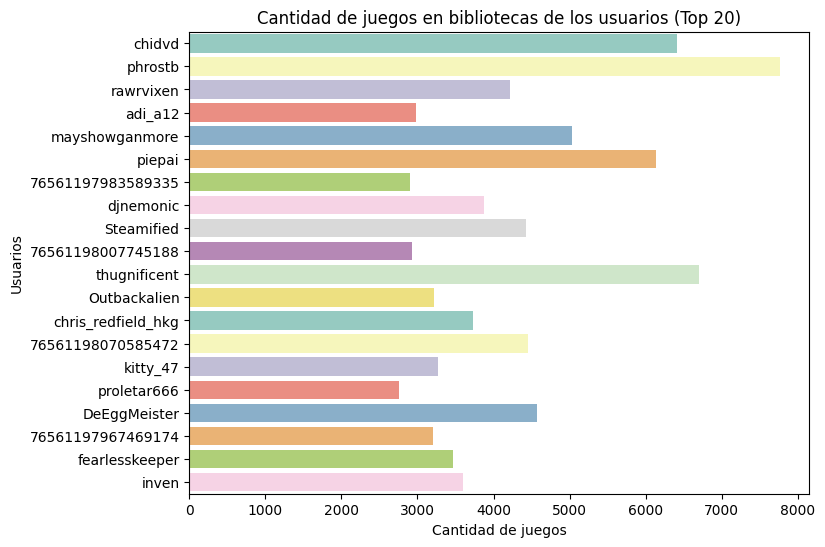

In [42]:
# Filtrar los datos para obtener los mejores 15 o 20 juegos
top_juegos = df_i['user_id'].value_counts().nlargest(20)  # Cambia el número a 20 si deseas los mejores 20 juegos

# Establecer el estilo de la paleta de colores
sns.set_palette("pastel")

# Crear el gráfico de conteo con los mejores juegos
plt.figure(figsize=(8, 6))
sns.countplot(data=df_i[df_i['user_id'].isin(top_juegos.index)], y='user_id', orient='h', palette='Set3')
plt.title('Cantidad de juegos en bibliotecas de los usuarios (Top 20)')
plt.xlabel('Cantidad de juegos')
plt.ylabel('Usuarios')

# Mostrar el gráfico
plt.show()

Se puede ver que el usuario que mas cantidad de juegos tiene en su librería, ronda los 8000 juegos, pero el 75% de los usuarios ha adquirido menos de 87 items. Considerando que hay muchos juegos free to play, o que steam cada cierto tiempo los regala algunos títulos para fomentar el uso de la plataforma, no se puede considerar que tener 8000 titulos en la librerís sea un valor erróneo, considerando tambien, la cantidad de años que hace que la aplicación steam funciona, y que hay varios usuarios con miles de títulos en sus librerías.

#### Carga del Datasets

In [45]:
df_g.to_parquet(r"C:\Users\Cebol\OneDrive\Escritorio\huevosDeCampo\Datasets_originales_limpios\steam_games_limpio.parquet", index=False)
df_r.to_parquet(r"C:\Users\Cebol\OneDrive\Escritorio\huevosDeCampo\Datasets_originales_limpios\australian_user_reviews_limpio.parquet", index=False)

# Convierte el DataFrame a un objeto Table de PyArrow
table = pa.Table.from_pandas(df_i)

# Define las opciones de compresión con Snappy
compression = 'snappy'

# Guarda el objeto Table en formato Parquet con compresión Snappy
pq.write_table(table, r'C:\Users\Cebol\OneDrive\Escritorio\Datasets\Datasets\australian_users_items_limpio_snappy.parquet', compression=compression)

